In [1]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn


In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
# Setting up the feature extractor w gabor filter bank

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

# n_ori = 36
n_ori = 8
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 4.13
pix_per_cycle = 20

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    

x,y,sigma = [0,0,0.05]


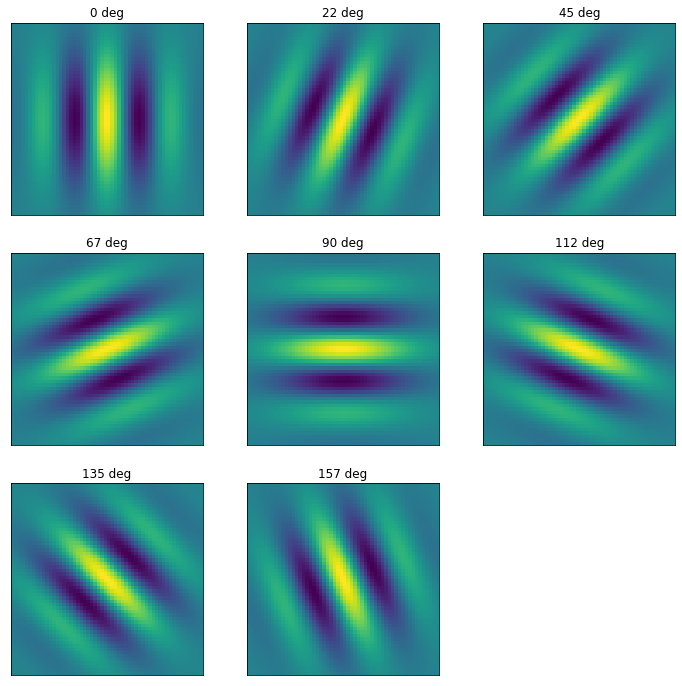

In [4]:
## Visualize the orientation filters (also double check the labels for degrees here)
# Note these are complex numbers, showing real parts only here. If you plot imaginary, will be 90 deg out of phase.

plt.figure(figsize=(12,12));
for ff in range(8):
    
    plt.subplot(3,3,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,0,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

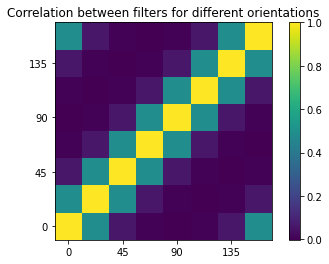

In [7]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[2:4])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

(0.0, 56.0, 0.0, 56.0)

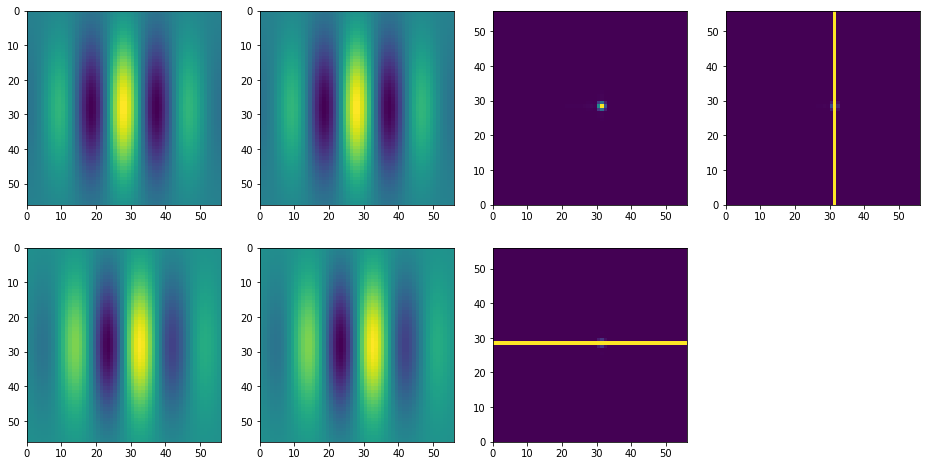

In [8]:
# figuring out FWHM of the filters

from scipy import fft, ifft

gabor_spat1 = orient_filters[0,0,:,:]
gabor_freq1 = fft.fftshift(fft.fft2(gabor_spat1))
gabor_spat1_new = fft.ifft2(fft.ifftshift(gabor_freq1))

plt.figure(figsize=(16,8));

# Original spatial filter
plt.subplot(2,4,1)
plt.pcolormesh(np.real(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,5)
plt.pcolormesh(np.imag(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()
# flipping the y axis here - so positive orientation is rotating clockwise from vertical.


# converted back to spatial domain (check)

plt.subplot(2,4,2)
plt.pcolormesh(np.real(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,6)
plt.pcolormesh(np.imag(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()


# Frequency domain

# plt.subplot(2,4,3)
# plt.pcolormesh(np.real(gabor_freq1))
# plt.axis('square')

plt.subplot(2,4,3)
plt.pcolormesh(np.abs(gabor_freq1))
plt.axis('square')

# get cross-section


maxind0 = np.argmax(np.max(np.abs(gabor_freq1),axis=1))
maxind1 = np.argmax(np.max(np.abs(gabor_freq1),axis=0))

plt.subplot(2,4,4)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[:,maxind1] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')

plt.subplot(2,4,7)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[maxind0,:] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')



fwhm = 36.870


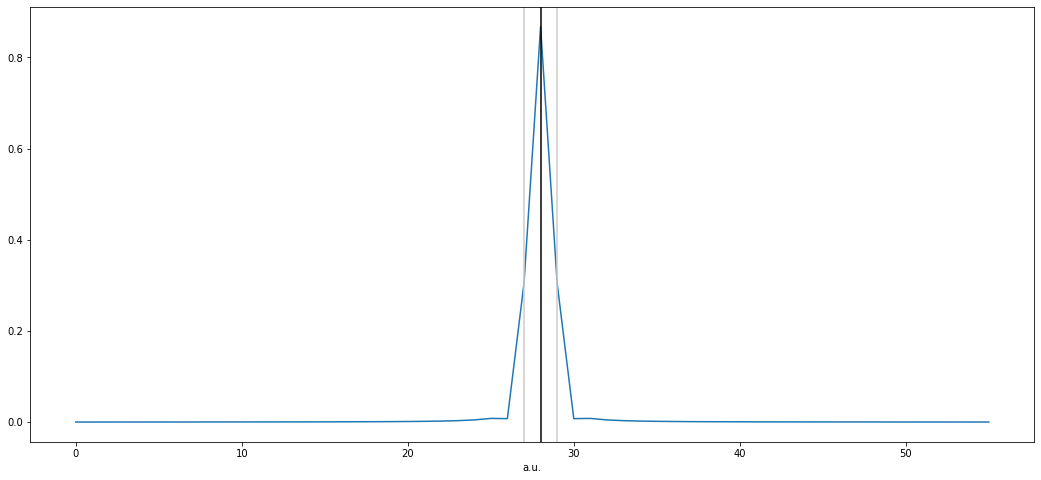

In [9]:
# Estimating the filter's orientation bandwidth, empirically. 
# Take a cross-section in frequency domain and see how wide it is (full-width at half max)

plt.figure(figsize=(18,8))
cross_sect = np.abs(gabor_freq1[:,maxind1])
plt.plot(cross_sect)
plt.axvline(maxind0,color='k')
half_height = (cross_sect[maxind0] - np.min(cross_sect))/2
closest_x = np.argsort(np.abs(cross_sect - half_height))[0:2]
plt.axvline(closest_x[0],color=[0.8, 0.8, 0.8])
plt.axvline(closest_x[1],color=[0.8, 0.8, 0.8])
plt.xlabel('a.u.')

# width of the gabor in freq domain
fwhm_au = np.abs(np.diff(closest_x))[0]

centerind = maxind0 # only true since orientation = 0

# distance of centroid of the gabor from center
sf_au = maxind1 - centerind

# the units in this space encode spatial frequency and orientation as radius and angle in polar coords.
# current distances in a.u. are units of SF.
# to get to orientation, use:
# tan(theta) = opp/adjacent
# tan(orientation FWHM/2) = (bandwidth in SF units/2 / distance from center in SF units)

orient_bw_rad = 2*np.arctan(fwhm_au/2/sf_au)
orient_bw_deg = orient_bw_rad/(np.pi)*180

orient_bw_deg
print('fwhm = %.3f'%orient_bw_deg)



In [10]:
# Other filtering method...
import gfb_utils as g

n_ori = 8
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
# spat_aspect_ratio = 0.5
n_sd_out = 2.5

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [11]:
## Testing spatial version

n_images= 100
sample_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

# maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

# print(np.shape(maps_spat))

# elapsed_total = time.time() - t_start
# print('total time is %.2f s'%elapsed_total)

took 0.41 s to make filters


In [14]:
len(gfe.filters_spat)

12

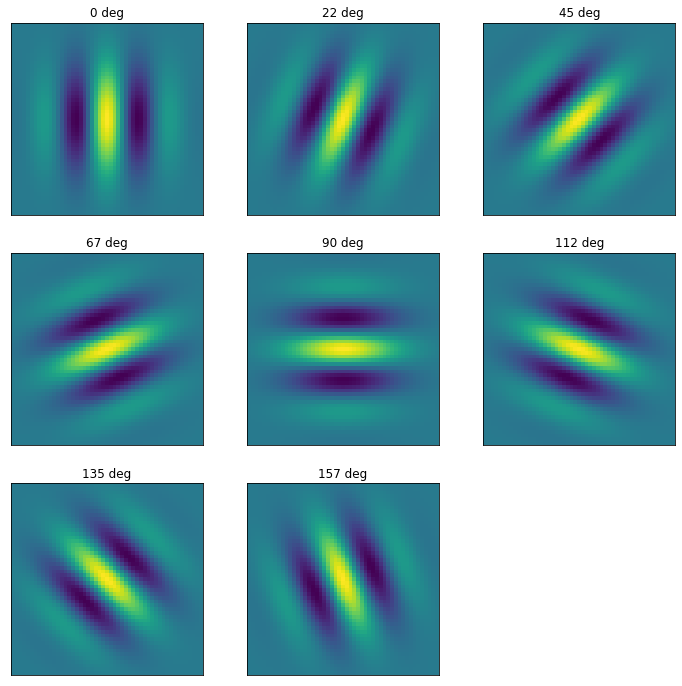

In [12]:
## Visualize the orientation filters (these are different sizes for different SFs)
sf=5
orient_filters = gfe.filters_spat[sf].cpu().detach().numpy()

plt.figure(figsize=(12,12));
for ff in range(8):
    
    plt.subplot(3,3,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

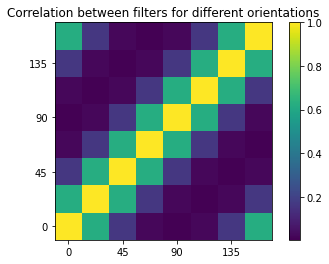

In [13]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[1:3])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

(0.0, 51.0, 0.0, 51.0)

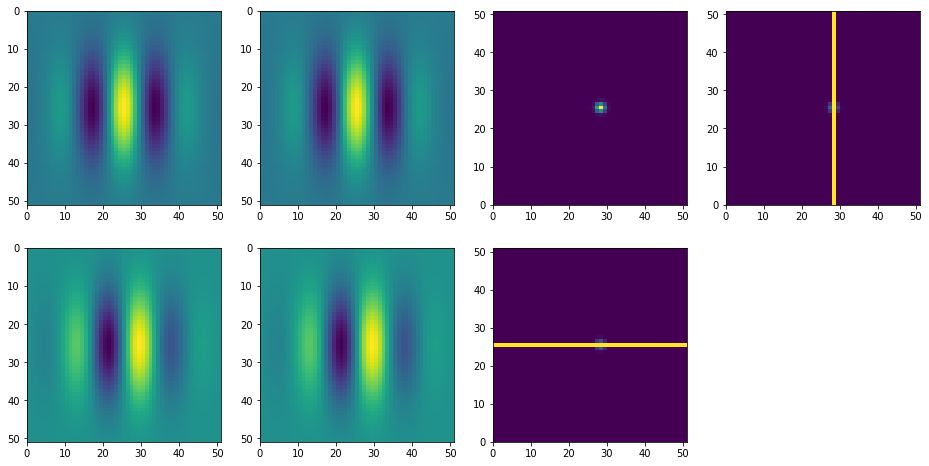

In [14]:
# figuring out FWHM of the filters

from scipy import fft, ifft

gabor_spat1 = orient_filters[0,:,:]
gabor_freq1 = fft.fftshift(fft.fft2(gabor_spat1))
gabor_spat1_new = fft.ifft2(fft.ifftshift(gabor_freq1))

plt.figure(figsize=(16,8));

# Original spatial filter
plt.subplot(2,4,1)
plt.pcolormesh(np.real(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,5)
plt.pcolormesh(np.imag(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()
# flipping the y axis here - so positive orientation is rotating clockwise from vertical.


# converted back to spatial domain (check)

plt.subplot(2,4,2)
plt.pcolormesh(np.real(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,6)
plt.pcolormesh(np.imag(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()


# Frequency domain

# plt.subplot(2,4,3)
# plt.pcolormesh(np.real(gabor_freq1))
# plt.axis('square')

plt.subplot(2,4,3)
plt.pcolormesh(np.abs(gabor_freq1))
plt.axis('square')

# get cross-section


maxind0 = np.argmax(np.max(np.abs(gabor_freq1),axis=1))
maxind1 = np.argmax(np.max(np.abs(gabor_freq1),axis=0))

plt.subplot(2,4,4)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[:,maxind1] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')

plt.subplot(2,4,7)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[maxind0,:] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')



In [226]:
fwhm_au

2

fwhm = 36.870


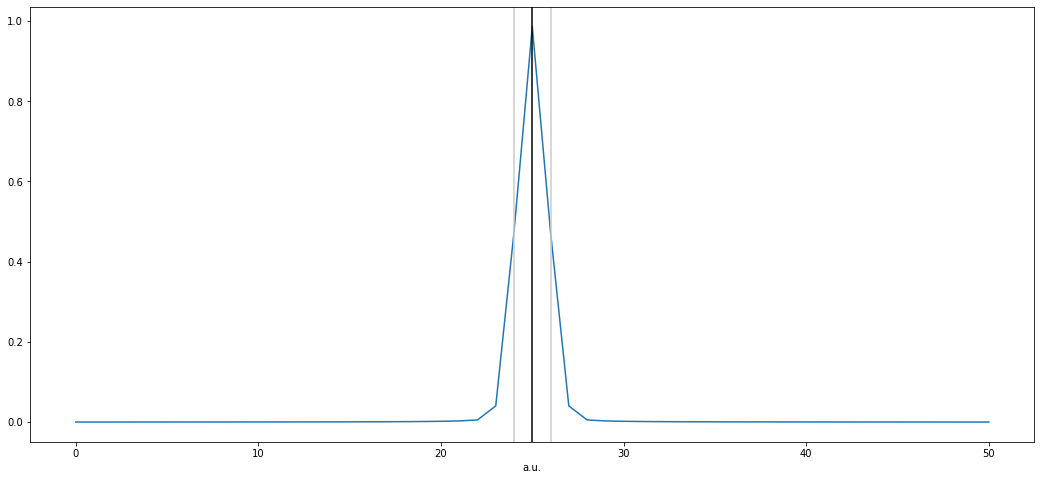

In [15]:
# Estimating the filter's orientation bandwidth, empirically. 
# Take a cross-section in frequency domain and see how wide it is (full-width at half max)

plt.figure(figsize=(18,8))
cross_sect = np.abs(gabor_freq1[:,maxind1])
plt.plot(cross_sect)
plt.axvline(maxind0,color='k')
half_height = (cross_sect[maxind0] - np.min(cross_sect))/2
closest_x = np.argsort(np.abs(cross_sect - half_height))[0:2]
plt.axvline(closest_x[0],color=[0.8, 0.8, 0.8])
plt.axvline(closest_x[1],color=[0.8, 0.8, 0.8])
plt.xlabel('a.u.')

# width of the gabor in freq domain
fwhm_au = np.abs(np.diff(closest_x))[0]

centerind = maxind0 # only true since orientation = 0

# distance of centroid of the gabor from center
sf_au = maxind1 - centerind

# the units in this space encode spatial frequency and orientation as radius and angle in polar coords.
# current distances in a.u. are units of SF.
# to get to orientation, use:
# tan(theta) = opp/adjacent
# tan(orientation FWHM/2) = (bandwidth in SF units/2 / distance from center in SF units)

orient_bw_rad = 2*np.arctan(fwhm_au/2/sf_au)
orient_bw_deg = orient_bw_rad/(np.pi)*180

orient_bw_deg
print('fwhm = %.3f'%orient_bw_deg)



In [16]:
# Changing aspect ratio...


import gfb_utils as g

n_ori = 8
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
# spat_aspect_ratio = 1
spat_aspect_ratio = 0.5
n_sd_out = 2.5

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [17]:
## Testing spatial version

n_images= 100
sample_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

# maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

# print(np.shape(maps_spat))

# elapsed_total = time.time() - t_start
# print('total time is %.2f s'%elapsed_total)

took 0.86 s to make filters


In [14]:
len(gfe.filters_spat)

12

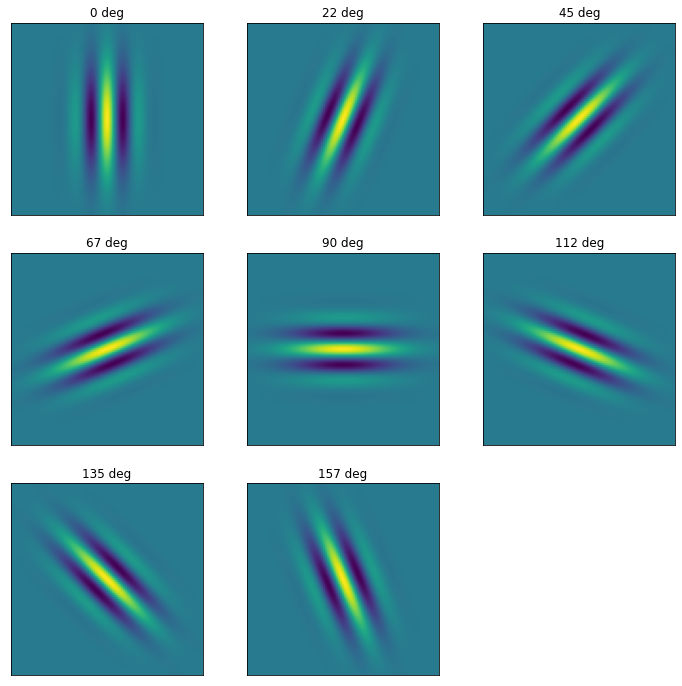

In [18]:
## Visualize the orientation filters (these are different sizes for different SFs)
sf=5
orient_filters = gfe.filters_spat[sf].cpu().detach().numpy()

plt.figure(figsize=(12,12));
for ff in range(8):
    
    plt.subplot(3,3,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

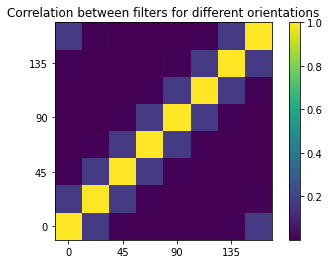

In [19]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[1:3])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

(0.0, 101.0, 0.0, 101.0)

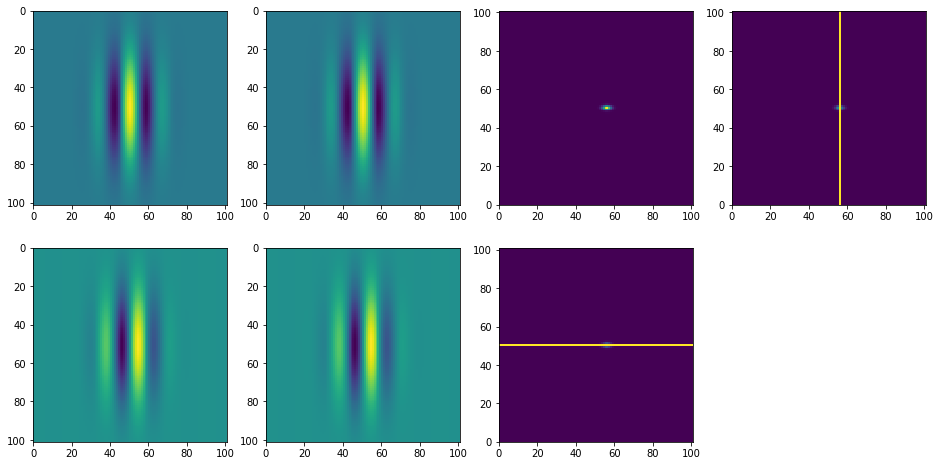

In [20]:
# figuring out FWHM of the filters

from scipy import fft, ifft

gabor_spat1 = orient_filters[0,:,:]
gabor_freq1 = fft.fftshift(fft.fft2(gabor_spat1))
gabor_spat1_new = fft.ifft2(fft.ifftshift(gabor_freq1))

plt.figure(figsize=(16,8));

# Original spatial filter
plt.subplot(2,4,1)
plt.pcolormesh(np.real(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,5)
plt.pcolormesh(np.imag(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()
# flipping the y axis here - so positive orientation is rotating clockwise from vertical.


# converted back to spatial domain (check)

plt.subplot(2,4,2)
plt.pcolormesh(np.real(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,6)
plt.pcolormesh(np.imag(gabor_spat1_new))
plt.axis('square')
plt.gca().invert_yaxis()


# Frequency domain

# plt.subplot(2,4,3)
# plt.pcolormesh(np.real(gabor_freq1))
# plt.axis('square')

plt.subplot(2,4,3)
plt.pcolormesh(np.abs(gabor_freq1))
plt.axis('square')

# get cross-section


maxind0 = np.argmax(np.max(np.abs(gabor_freq1),axis=1))
maxind1 = np.argmax(np.max(np.abs(gabor_freq1),axis=0))

plt.subplot(2,4,4)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[:,maxind1] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')

plt.subplot(2,4,7)
gab_freq_wline = np.abs(gabor_freq1)
gab_freq_wline[maxind0,:] = 2
plt.pcolormesh(gab_freq_wline)
plt.axis('square')



In [226]:
fwhm_au

2

fwhm = 18.925


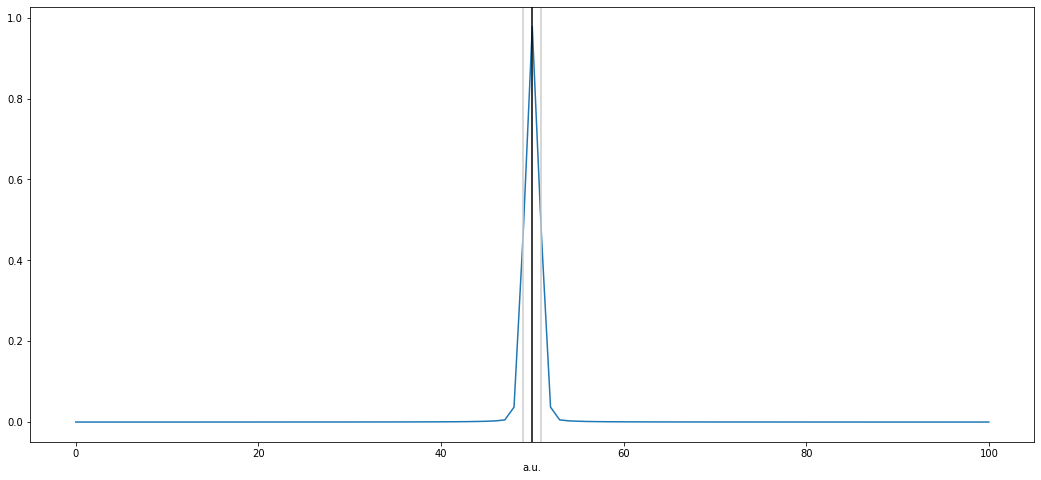

In [21]:
# Estimating the filter's orientation bandwidth, empirically. 
# Take a cross-section in frequency domain and see how wide it is (full-width at half max)

plt.figure(figsize=(18,8))
cross_sect = np.abs(gabor_freq1[:,maxind1])
plt.plot(cross_sect)
plt.axvline(maxind0,color='k')
half_height = (cross_sect[maxind0] - np.min(cross_sect))/2
closest_x = np.argsort(np.abs(cross_sect - half_height))[0:2]
plt.axvline(closest_x[0],color=[0.8, 0.8, 0.8])
plt.axvline(closest_x[1],color=[0.8, 0.8, 0.8])
plt.xlabel('a.u.')

# width of the gabor in freq domain
fwhm_au = np.abs(np.diff(closest_x))[0]

centerind = maxind0 # only true since orientation = 0

# distance of centroid of the gabor from center
sf_au = maxind1 - centerind

# the units in this space encode spatial frequency and orientation as radius and angle in polar coords.
# current distances in a.u. are units of SF.
# to get to orientation, use:
# tan(theta) = opp/adjacent
# tan(orientation FWHM/2) = (bandwidth in SF units/2 / distance from center in SF units)

orient_bw_rad = 2*np.arctan(fwhm_au/2/sf_au)
orient_bw_deg = orient_bw_rad/(np.pi)*180

orient_bw_deg
print('fwhm = %.3f'%orient_bw_deg)

